In [1]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
from scipy import misc
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]

In [2]:
raw_path = 'D:/winter intern roro/'

img1 = cv2.imread(os.path.join(raw_path,'170cell.png'))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
ori_img = img1.copy()
img2_ = cv2.imread(os.path.join(raw_path, '170dots.png'))
img2_ = cv2.cvtColor(img2_, cv2.COLOR_BGR2RGB)
img2 = 100.0 * (img2_[:,:,0] > 0) # Converting dotted to gray scale and 100 is a scaling factor which is later divided to get count.
img2 = ndimage.gaussian_filter(img2, sigma=(1, 1), order=0)
print('Shape of original dotted image: ', img2_.shape)
print('Shape of transformed image: ', img2.shape)

Shape of original dotted image:  (256, 256, 3)
Shape of transformed image:  (256, 256)


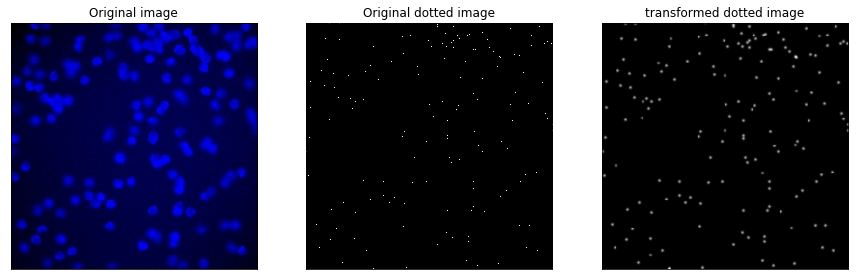

In [3]:
plt.rcParams["figure.figsize"] = [15,8]
plt.subplot(1,3,1), plt.imshow(img1), plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2), plt.imshow(img2_[:,:,0],cmap = 'gray'), plt.title('Original dotted image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3), plt.imshow(img2, cmap = 'gray'), plt.title('transformed dotted image'), plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
print('Number of cells in original dotted image: ',(img2_[:,:,0]>10).sum())
print('Number of cells in transformed dotted image: ',np.sum(img2)//100) # 100 is scaling factor which was multiplied in transformation

Number of cells in original dotted image:  159
Number of cells in transformed dotted image:  159.0


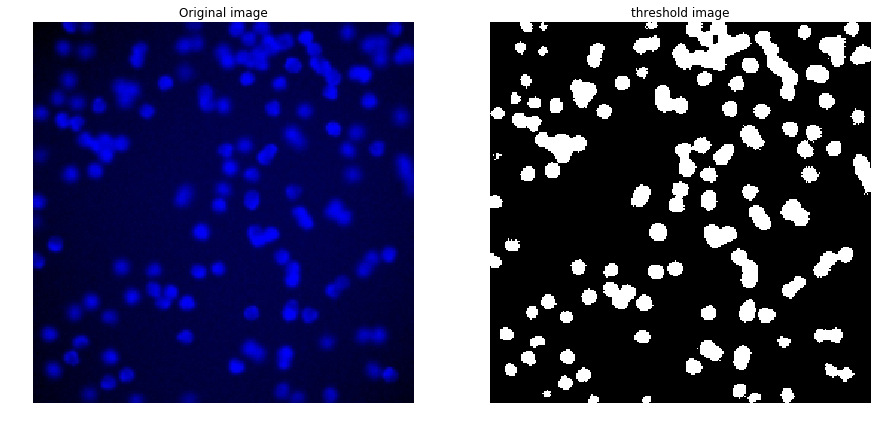

In [5]:
# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
# shifted = cv2.pyrMeanShiftFiltering(img1, 21, 51)
 
# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.subplot(1,2,1),plt.imshow(img1), plt.title("Original image")
plt.axis('off')
plt.subplot(1,2,2),plt.imshow(thresh, cmap='gray'), plt.title("threshold image")
plt.axis('off')
plt.show()

In [6]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=2,labels=thresh) # min_distance needs to be tuned.
 
# perform a connected component analysis on the local peaks
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax)[0]
labels = watershed(-D, markers, mask=thresh)
print("Number of Cells found: {}".format(len(np.unique(labels)) - 1))

Number of Cells found: 155


Number of Cells found: 155


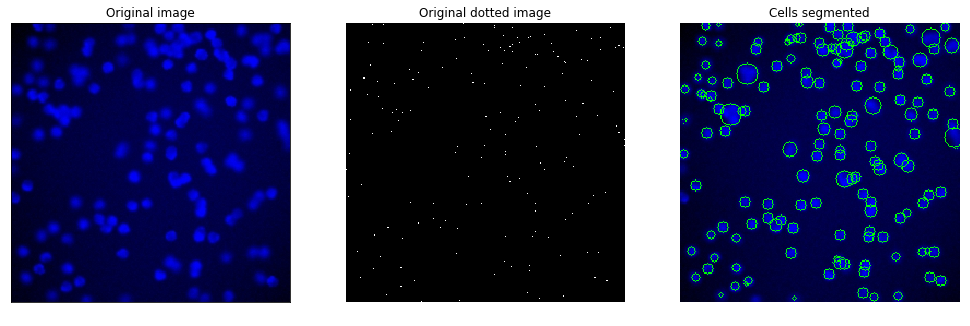

In [7]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(img1, (int(x), int(y)), int(r), (0, 255, 0), 1)

print("Number of Cells found: {}".format(len(np.unique(labels)) - 1))

plt.rcParams["figure.figsize"] = [17,8] ## To display better resolution image

plt.subplot(1,3,1), plt.imshow(ori_img), plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2), plt.imshow(img2_[:,:,0],cmap = 'gray'), plt.title('Original dotted image'), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(img1), plt.title('Cells segmented'), plt.axis('off')
plt.show();